In [4]:
import sys
sys.path.append("../dataset/")

import datetime
import glob
import json
import matplotlib.pyplot as plt
import nrrd
import numpy as np
import os
import tensorflow as tf
from keras_unet_collection import losses

from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from dataset import UltraSoundImages
from keras_unet_collection import models
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img
# from utils import plot_history

In [5]:
# Prepare data generator
raw_dir = "../RawUSGimagesNRRD"
raw_images = raw_dir + "/data_output"
raw_masks = raw_dir + "/masks"

# raw_dir = "../dataUSGthyroid/samsung_processed"
# raw_images = raw_dir + "/images"
# raw_masks = raw_dir + "/masks"

raw_images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))
raw_masks_paths = sorted(glob.glob(raw_masks + '**/*', recursive=True))

TEST_LEN = 10
VAL_LEN = 60
TRAIN_LEN = len(raw_images_paths) - VAL_LEN - TEST_LEN

batch_size = 8

train_images = raw_images_paths[:TRAIN_LEN]
validation_images = raw_images_paths[-(VAL_LEN+TEST_LEN):-TEST_LEN]
test_images =  raw_images_paths[-TEST_LEN:]

train_masks = raw_masks_paths[:TRAIN_LEN]
validation_masks = raw_masks_paths[-(VAL_LEN+TEST_LEN):-TEST_LEN]
test_masks =  raw_masks_paths[-TEST_LEN:]

train_gen = UltraSoundImages(batch_size, train_images, train_masks, size=(256,256))
val_gen = UltraSoundImages(batch_size, validation_images, validation_masks, size=(256,256))
test_gen = UltraSoundImages(batch_size, test_images, test_masks, size=(256,256))

Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading


In [26]:
images, masks = val_gen.__getitem__(1)
image = images[1]
mask = masks[1]

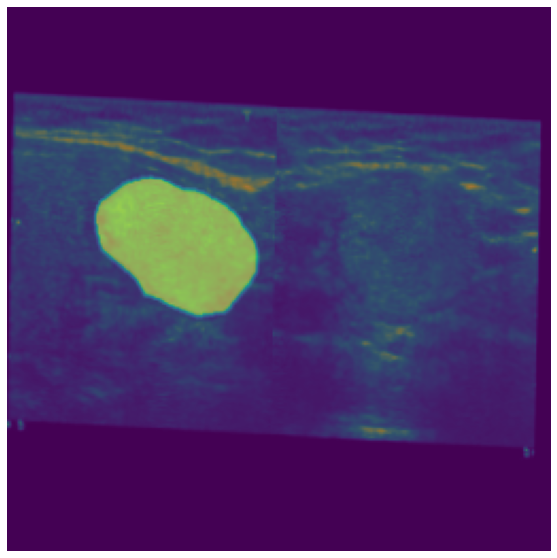

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.axis('off')
plt.show()

In [6]:
class ModelTester:
    
    def __init__(self, path_to_model, ds_gen, custom_objects=None):
        self.path_to_model = path_to_model
        self.custom_objects = custom_objects
        self.base_path = f'output/{path_to_model}'
        self.model_path = f'{self.base_path}model/model'
        self.meta_path = f'{self.base_path}meta/'
        self.images, self.masks = ds_gen.__getitem__(1)
        self.history = json.load(open(self.meta_path+'history.json'))
        self.model  = model = tf.keras.models.load_model(self.model_path, custom_objects=custom_objects)
    
    
    def plot_history(self):
        # Extract the history values
        loss = self.history['loss']
        acc = self.history['accuracy']
        val_loss = self.history['val_loss']
        val_acc = self.history['val_accuracy']

        # Plot the loss values
        plt.figure(figsize=(16, 8))
        plt.plot(loss)
        plt.plot(val_loss)
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Training', 'Validation'])
        plt.show()

        # Plot the accuracy values
        plt.figure(figsize=(16, 8))
        plt.plot(acc)
        plt.plot(val_acc)
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Training', 'Validation'])
        plt.show()
    
        
    def make_prediction(self):
        output_masks = self.model.predict(self.images)
        
        
        
        # plt.figure(figsize=(10, 10))
        # plt.imshow(self.images[0])
        # plt.imshow(self.masks[0], alpha=0.5)
        # plt.axis('off')
        # plt.show()
        # plt.figure(figsize=(10, 10))
        # plt.imshow(self.images[0])
        # plt.imshow(self.output_mask[0], alpha=0.5)
        # plt.axis('off')
        # plt.show()
    

In [9]:
u2_net_tester = ModelTester('u2net_2d/2023-04-13-07-48-28/', val_gen, custom_objects)

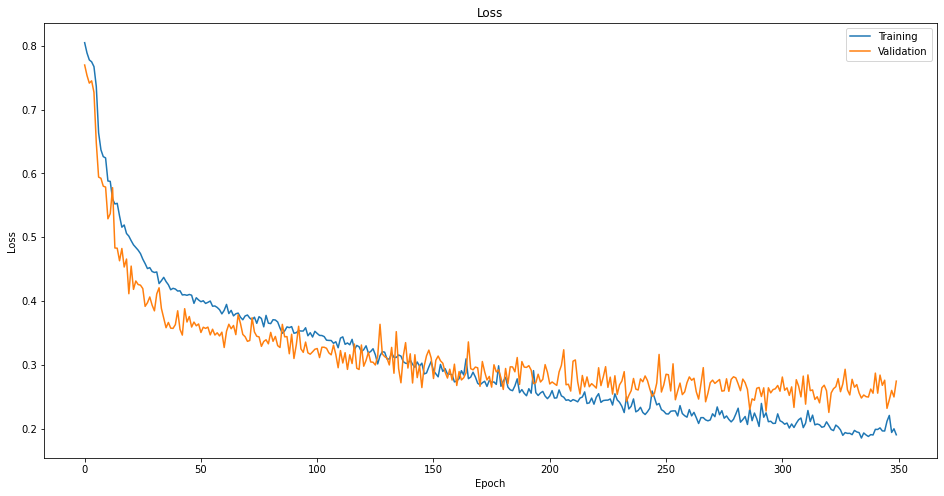

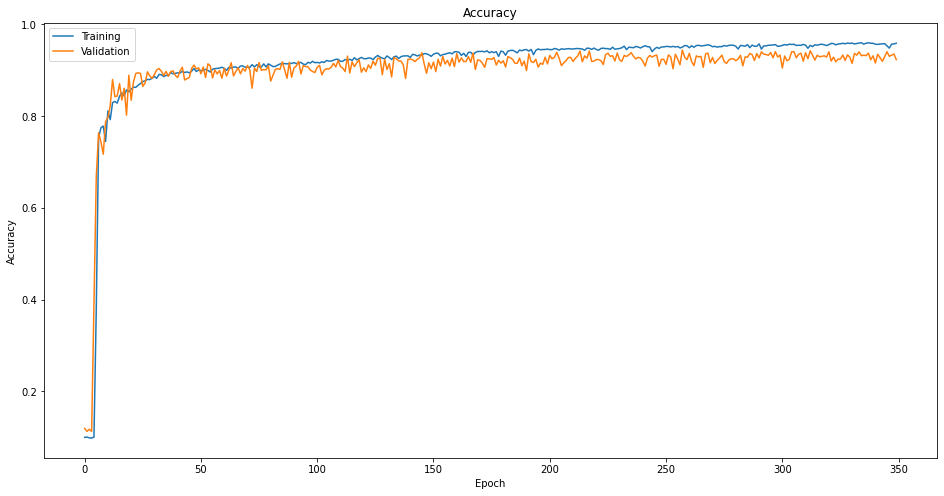

In [10]:
u2_net_tester.plot_history()

In [ ]:
u2_net_tester.make_prediction()

In [6]:
def plot_history(history):
    # Extract the history values
    loss = history['loss']
    acc = history['accuracy']
    val_loss = history['val_loss']
    val_acc = history['val_accuracy']

    # Plot the loss values
    plt.figure(figsize=(16, 8))
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # Plot the accuracy values
    plt.figure(figsize=(16, 8))
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.show()

In [8]:
def cutom_focal_tversky(y_true, y_pred, alpha=0.7, gamma=4/3):
    
    return losses.focal_tversky(y_true, y_pred, alpha=alpha, gamma=gamma)

custom_objects = {'cutom_focal_tversky': cutom_focal_tversky}

## Load Model

In [6]:
def create_report(path, model_summary=False, custom_objects=None):
    base_path = f'output/{path}'
    model_path = f'{base_path}model/model'
    meta_path = f'{base_path}meta/'
    history = json.load(open(meta_path+'history.json'))
    plot_history(history)
    custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    
    
    output_masks = model.predict(np.expand_dims(images, 3))
    cm = confusion_matrix(flat_truth, flat_preds(masks, output_masks))
    print(cm)
    
    # output_mask = model.predict(np.expand_dims(image, axis=[0,3]))[0]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(output_mask, alpha=0.5)
    plt.axis('off')
    plt.show()
    
    if model_summary:
        print(model.summary())

### Classic U-Net

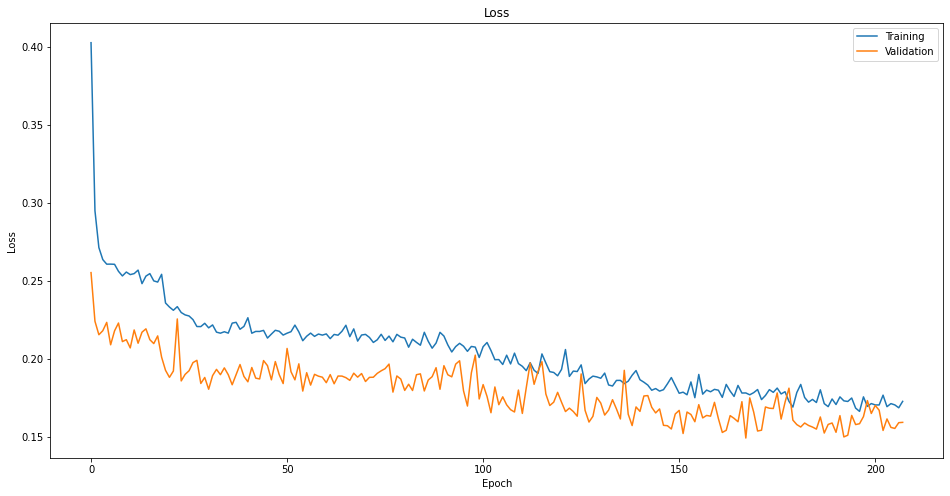

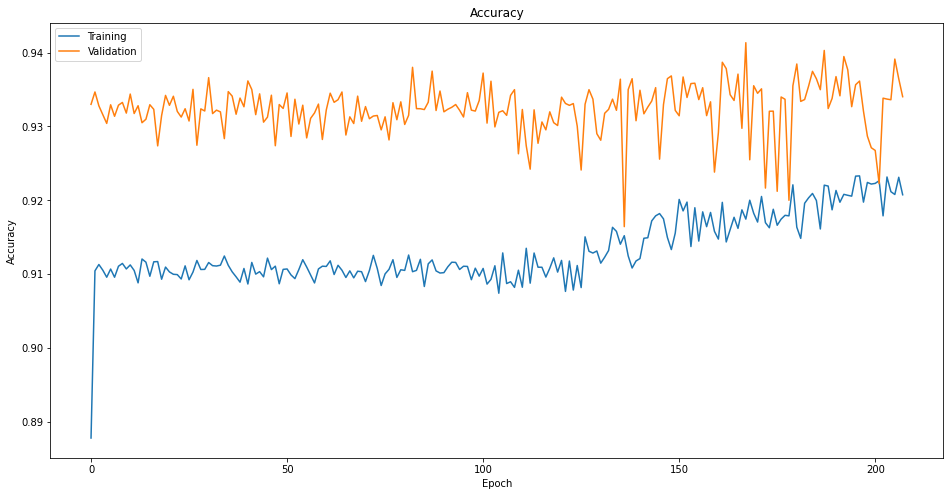

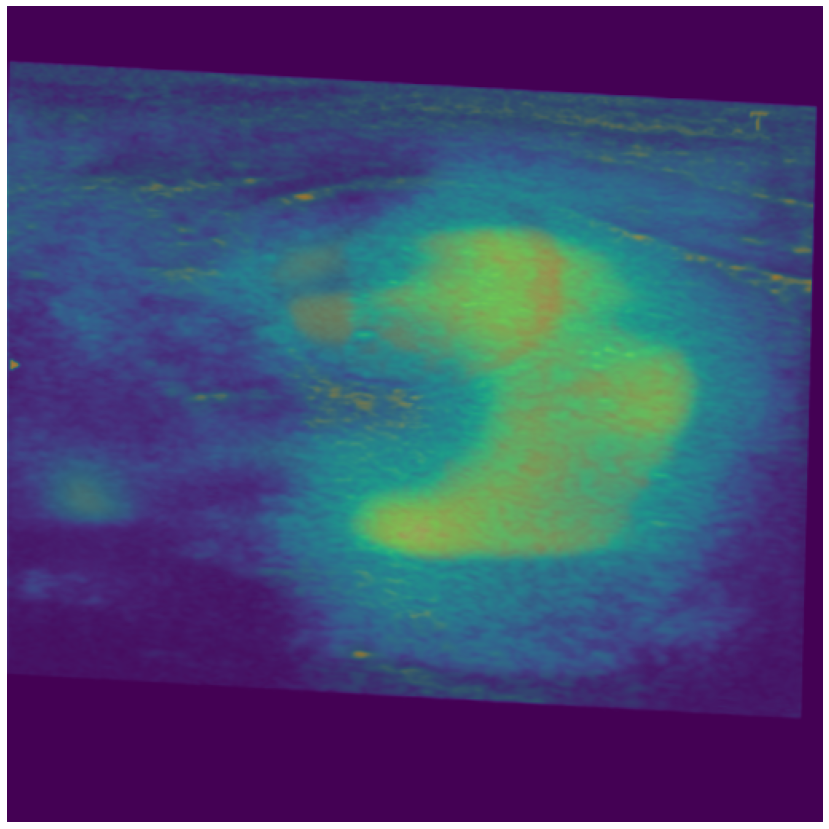

Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_activation (ReLU)  (None, 512, 512, 64) 0           unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_1 (Conv2D)           (None, 512, 512, 64) 36928       unet_down0_0_activation[0][0]    
_________________________________________________________________________________________

In [9]:
create_report('unet_2d/2023-04-03-20-00-39/')

### U^2-Net

In [18]:
train_gen = UltraSoundImages(batch_size, train_images, train_masks, size=(512,512))
val_gen = UltraSoundImages(batch_size, validation_images, validation_masks, size=(512,512))
test_gen = UltraSoundImages(batch_size, test_images, test_masks, size=(512,512))

Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading


In [19]:
images, masks = val_gen.__getitem__(5)
image = images[0]
mask = masks[0]

In [ ]:
np.max(masks)

In [ ]:
np.min(output_masks.flatten())

In [ ]:
cm = confusion_matrix(np.round(masks.flatten()), np.round(output_masks.flatten()), labels=[0,1])
# print(cm)

In [ ]:
cm

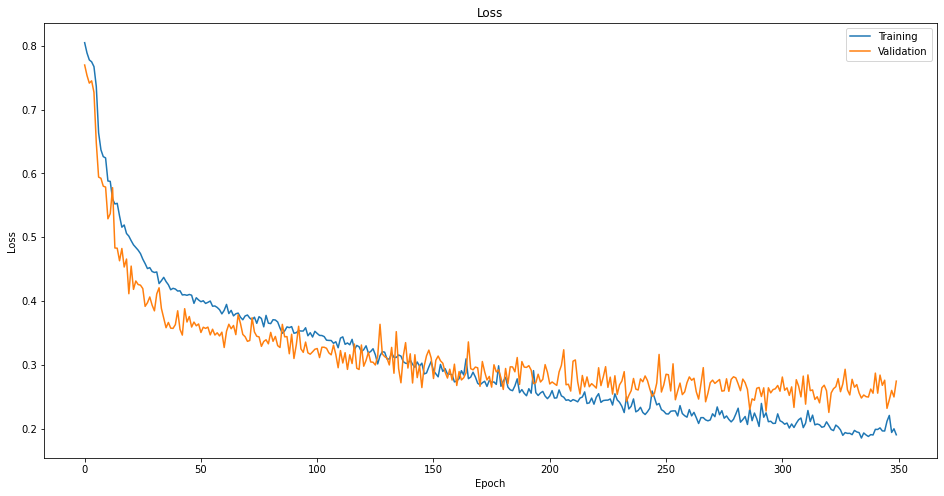

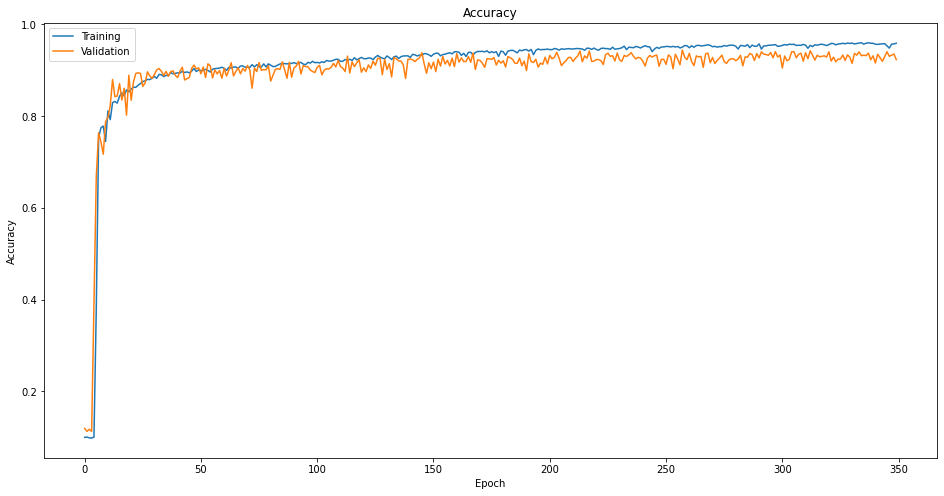

In [8]:
base_path='output/u2net_2d/2023-04-13-07-48-28/'
model_path = f'{base_path}model/model'
# meta_path = f'{base_path}meta/'
# history = json.load(open(meta_path+'history.json'))
# plot_history(history)
# model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
model_path = f'{base_path}model/model'
meta_path = f'{base_path}meta/'
history = json.load(open(meta_path+'history.json'))
plot_history(history)
custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# output_masks = model.predict(np.expand_dims(images, 3))
# cm = confusion_matrix(flat_truth, flat_preds(masks, output_masks))
# print(cm)

In [9]:
output_mask = model.predict(np.expand_dims(image, axis=[0,3]))[0]

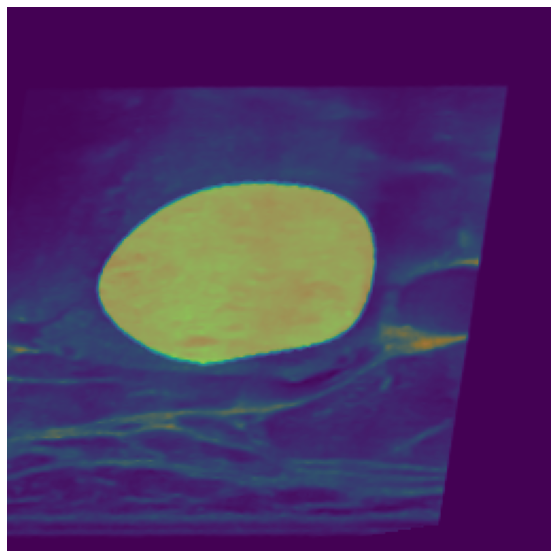

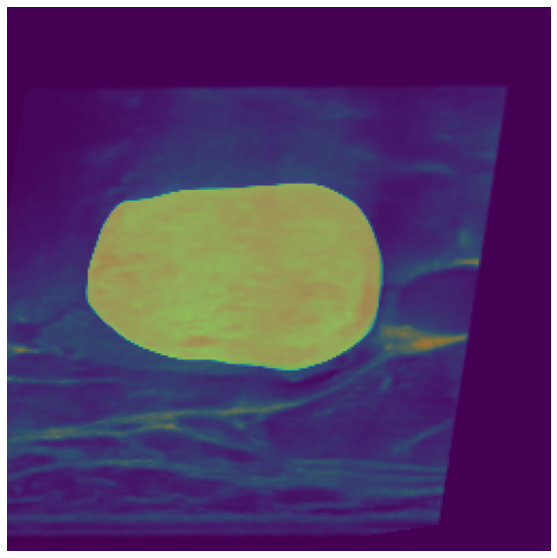

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(output_mask, alpha=0.5)
plt.axis('off')
plt.show()

### Model trained on Samunsung DS performance on DS

In [27]:
output_mask = model.predict(np.expand_dims(image, axis=[0,3]))[0]

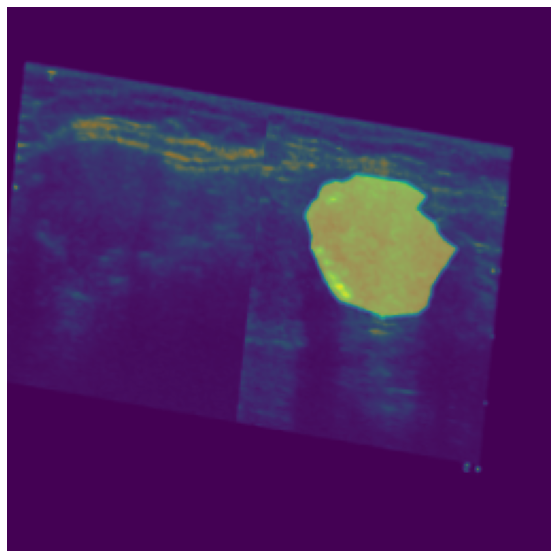

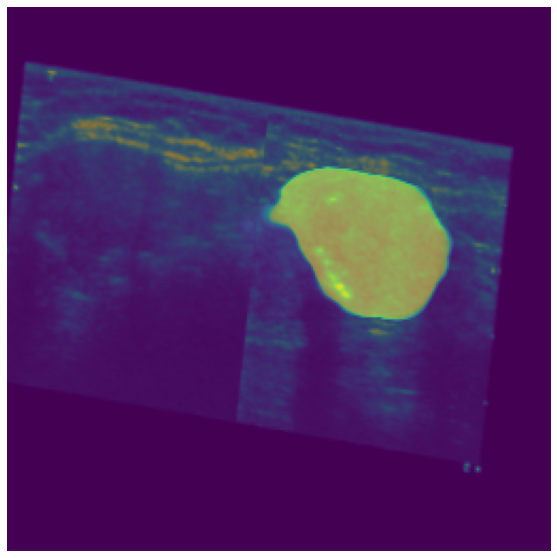

In [28]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(output_mask, alpha=0.5)
plt.axis('off')
plt.show()

In [ ]:
# custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
# # create_report('u2net_2d/2023-04-08-07-58-40/', custom_objects)
# create_report('u2net_2d/2023-04-13-07-48-28/', custom_objects)

### U-Net 3+

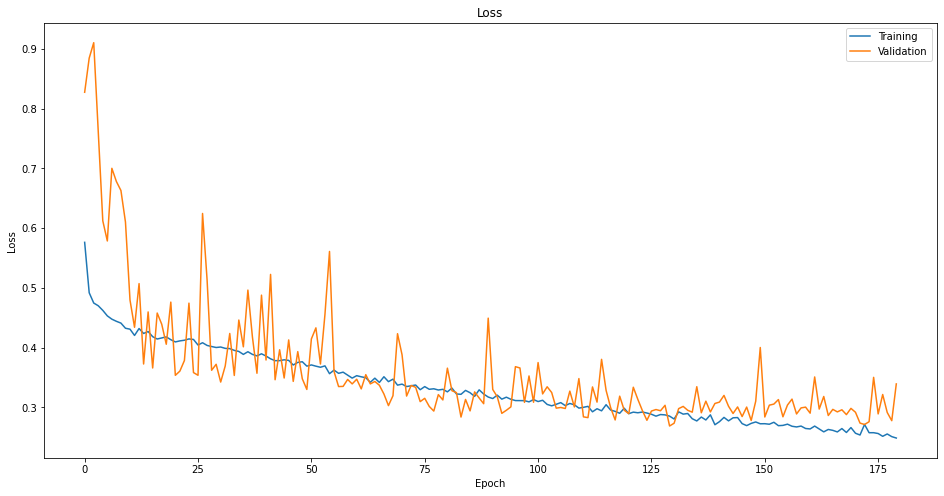

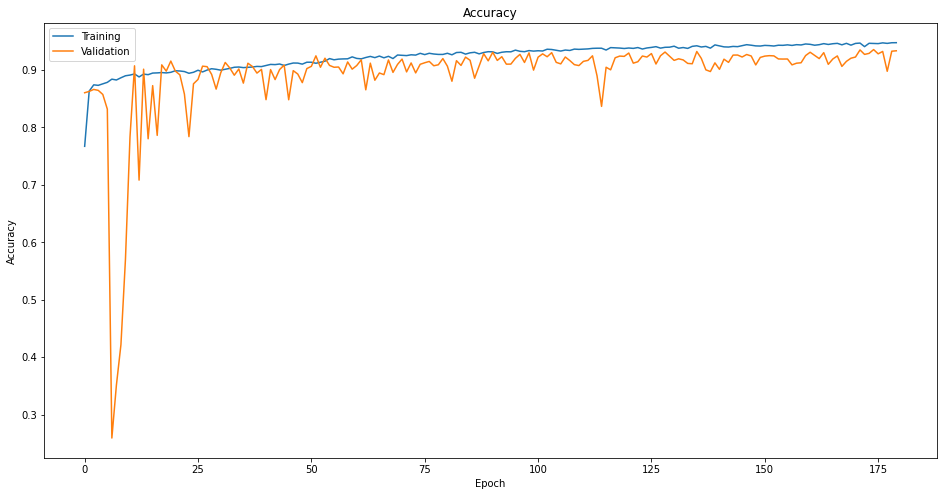

In [12]:
base_path='output/unet_3plus_2d/2023-04-12-20-51-00/'
model_path = f'{base_path}model/model'
# meta_path = f'{base_path}meta/'
# history = json.load(open(meta_path+'history.json'))
# plot_history(history)
# model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
model_path = f'{base_path}model/model'
meta_path = f'{base_path}meta/'
history = json.load(open(meta_path+'history.json'))
plot_history(history)
custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

In [13]:
output_mask = model.predict(np.expand_dims(image, axis=[0,3]))[0]

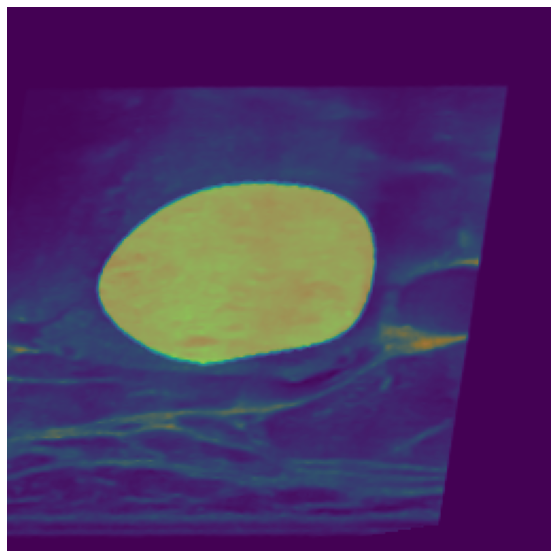

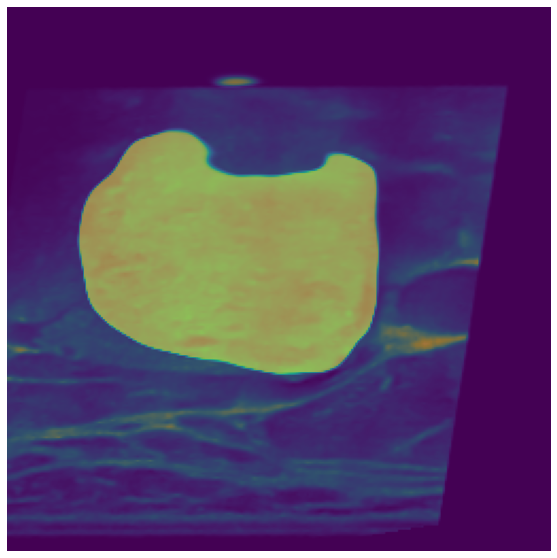

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(output_mask, alpha=0.5)
plt.axis('off')
plt.show()

In [28]:
output_mask = model.predict(np.expand_dims(image, axis=[0,3]))[0]

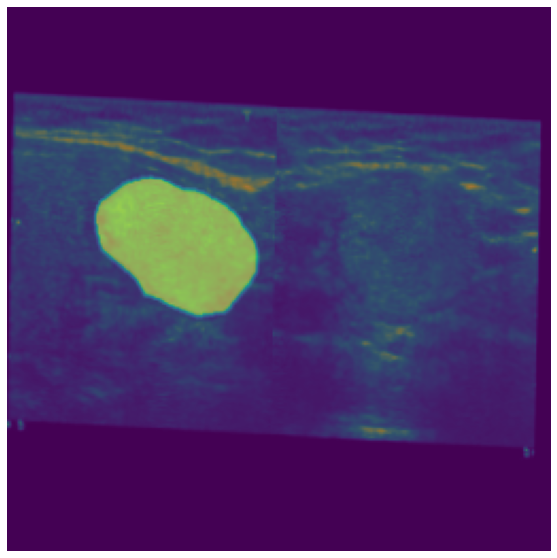

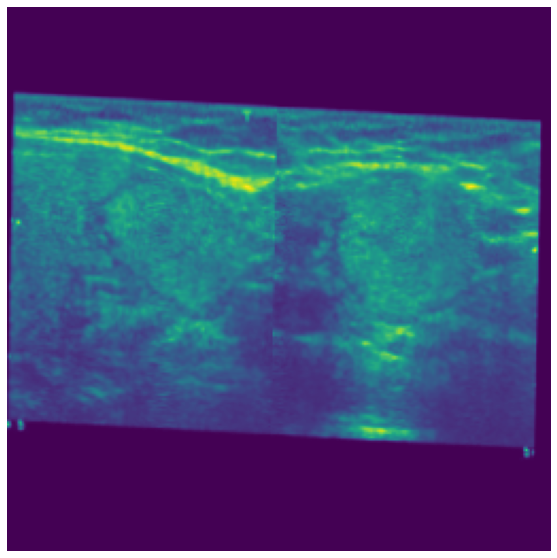

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(image)
# plt.imshow(output_mask, alpha=0.5)
plt.axis('off')
plt.show()

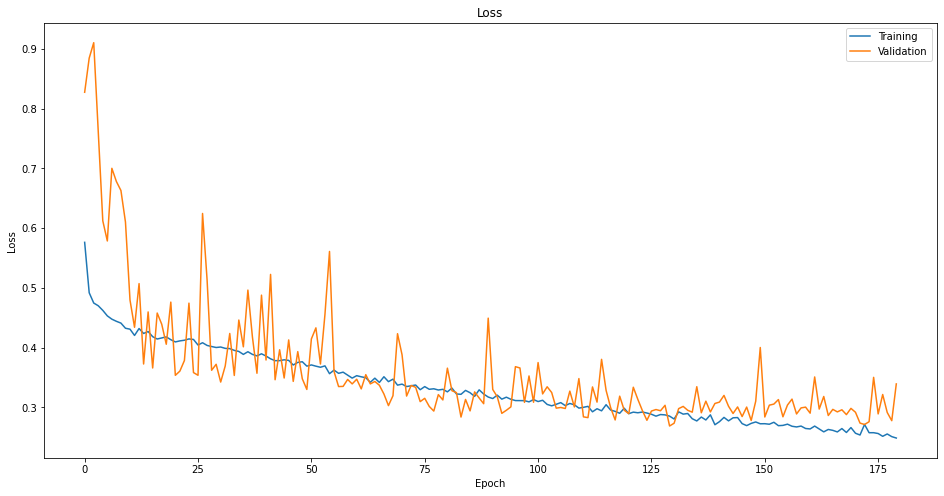

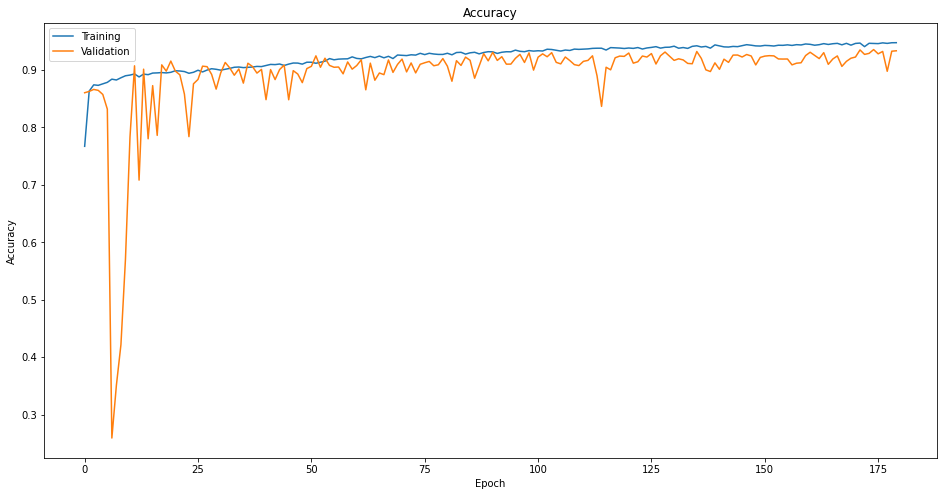

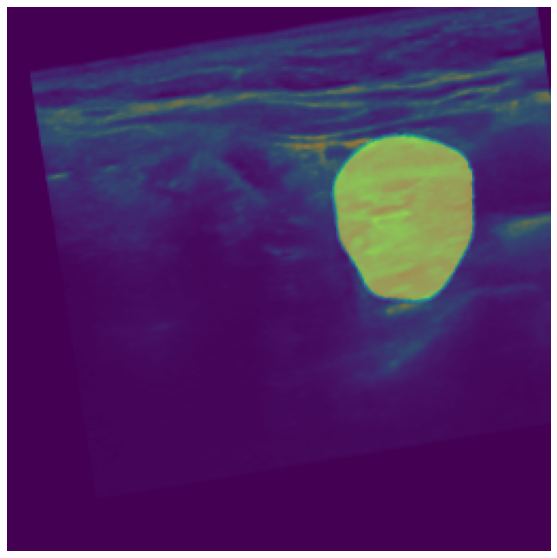

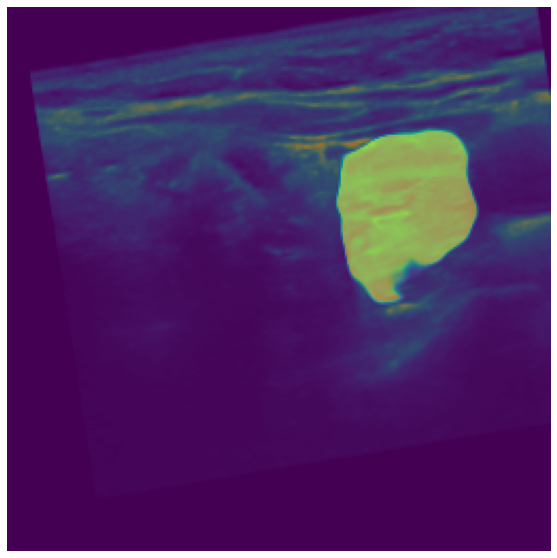

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
unet3plus_down0_0 (Conv2D)      (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
unet3plus_down0_0_activation (R (None, 256, 256, 64) 0           unet3plus_down0_0[0][0]          
__________________________________________________________________________________________________
unet3plus_down0_1 (Conv2D)      (None, 256, 256, 64) 36928       unet3plus_down0_0_activation[0][0
______________________________________________________________________________________________

In [11]:
custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
create_report('unet_3plus_2d/2023-04-12-20-51-00/', custom_objects)
# create_report('unet_3plus_2d/2023-04-13-07-48-28/', custom_objects)

### Trans U-Net

### Swin U-Net